## Training on Cifar 10 Using MXNet and H2O


In [1]:
%matplotlib inline

import matplotlib
import scipy.io
import matplotlib.pyplot as plt

import cPickle
import numpy as np
from scipy.misc import imsave
from IPython.display import Image, display, HTML

## Step 1: Preprocess the data

In [2]:
!mkdir -p /tmp/cifar10

In [3]:
with open("/datasets/cifar-10-batches-py/batches.meta") as fd:
    meta = cPickle.load(fd)
print meta

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


In [4]:
def load_cifar10_image_list(filepath):
    images = []
    labels = []
    with open(filepath, 'rb') as fd:
        d = cPickle.load(fd)
        for image, label, filename in zip(d['data'], d['labels'], d['filenames']):
            x = np.array(image)
            x = np.dstack((x[:1024], x[1024:2048], x[2048:]))
            x = x.reshape(32,32,3)
            filename="/tmp/cifar10/"+filename
            imsave(filename, x)
            images.append(filename)
            labels.append(label)
    return images, labels

In [5]:
x_train = []
y_train = []

for batch in range(1,6):
    batch_name = '/datasets/cifar-10-batches-py/data_batch_%d' % batch
    x,y = load_cifar10_image_list(batch_name)
    x_train.extend(x)
    y_train.extend(y)

In [6]:
!ls /datasets/cifar-10-batches-py/

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


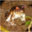

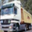

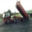

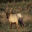

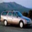

In [7]:
for x in x_train[:5]:
    display(Image(filename=x))

In [8]:
len(x_train)

50000

In [9]:
batch_test = '/datasets/cifar-10-batches-py/test_batch'
x_test, y_test = load_cifar10_image_list(batch_test)

In [10]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,16 mins 16 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,21 hours and 10 minutes
H2O cluster name:,fmilo
H2O cluster total nodes:,1
H2O cluster free memory:,13.56 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [11]:
train_df = {"x0": x_train, "x1": y_train }

In [12]:
test_df = {"x0" : x_test, "x1": y_test }

In [13]:
train_hf = h2o.H2OFrame.from_python(train_df)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [14]:
test_hf = h2o.H2OFrame.from_python(test_df)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


Let's 1 hot encode the class

In [15]:
train_hf['x1'] = train_hf['x1'].asfactor()
test_hf['x1'] = test_hf['x1'].asfactor()

In [16]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [30]:
vgg_model = H2ODeepWaterEstimator(
    epochs=10, 
    nfolds=2,
    learning_rate=1e-3, 
    mini_batch_size=64,
    network='VGG', 
    image_shape=[32,32], 
    channels=3,
    score_interval=0, 
    train_samples_per_iteration=1000,
    gpu=True
)

In [31]:
train_hf.head(10)

x0,x1
/tmp/cifar10/leptodactylus_pentadactylus_s_000004.png,6
/tmp/cifar10/camion_s_000148.png,9
/tmp/cifar10/tipper_truck_s_001250.png,9
/tmp/cifar10/american_elk_s_001521.png,4
/tmp/cifar10/station_wagon_s_000293.png,1
/tmp/cifar10/coupe_s_001735.png,1
/tmp/cifar10/cassowary_s_001300.png,2
/tmp/cifar10/cow_pony_s_001168.png,7
/tmp/cifar10/sea_boat_s_001584.png,8
/tmp/cifar10/tabby_s_001355.png,3


In [32]:
vgg_model.train(x=['x0'], y='x1', training_frame=train_hf, problem_type='image_classification')

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [33]:
error = vgg_model.model_performance(train=True).mean_per_class_error()
print "model error:", error

model error: 0.160169603959


## Predict 

In [22]:
random_test_image = test_df['x0'][int(np.random.random()*len(test_df))]

In [23]:
random_test_image

'/tmp/cifar10/hydrofoil_s_000078.png'

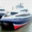

In [24]:
Image(filename=random_test_image)

In [ ]:
valid_nn_models = ['lenet', 'alexnet', 'vgg', 'resnet', 'inception', 'googlenet' ]